# Rossmann Store Sales - Final Project at Statistical Monitoring and Anomaly Detection
## Group 7

Almog Asraf

Daniel Pidtylok

Nir Levanon

Imports:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from sklearn.cluster import KMeans
import statistics
from fitter import Fitter, get_common_distributions, get_distributions
import hvplot
import hvplot.pandas
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, scale

Loading files into pandas dataframe:

In [2]:
path = "./rossmann-store-sales/"
store = pd.read_csv(f"{path}store.csv", encoding="utf8")
train = pd.read_csv(f"{path}train.csv", encoding="utf8")
# test = pd.read_csv(f"{path}test.csv", encoding="utf8")

C:\Users\yumi4\AppData\Local\Temp\ipykernel_23112\1146988513.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f"{path}train.csv", encoding="utf8")


In [3]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [4]:
train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [5]:
#test.head()

### Datasert Discription
We are provided with historical sales data for 1,115 Rossmann stores. Note that some stores in the dataset were temporarily closed for refurbishment.

#### Files
* train.csv - historical data including Sales
* test.csv - historical data excluding Sales
* sample_submission.csv - a sample submission file in the correct format
* store.csv - supplemental information about the stores
#### Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### Dataset Exploration

#### Calculate summary statictics:

In [6]:
store.describe()

Store  CompetitionDistance  CompetitionOpenSinceMonth  \
count  1115.00000          1112.000000                 761.000000   
mean    558.00000          5404.901079                   7.224704   
std     322.01708          7663.174720                   3.212348   
min       1.00000            20.000000                   1.000000   
25%     279.50000           717.500000                   4.000000   
50%     558.00000          2325.000000                   8.000000   
75%     836.50000          6882.500000                  10.000000   
max    1115.00000         75860.000000                  12.000000   

       CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear  
count                761.000000  1115.000000       571.000000       571.000000  
mean                2008.668857     0.512108        23.595447      2011.763573  
std                    6.195983     0.500078        14.141984         1.674935  
min                 1900.000000     0.000000         1.000000      2009.000000  
25%                 2006.000000     0.000000        13.000000      2011.000000  
50%                 2010.000000     1.000000        22.000000      2012.000000  
75%                 2013.000000     1.000000        37.000000      2013.000000  
max                 2015.000000     1.000000        50.000000      2015.000000

In [7]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [8]:
#test.describe()

In [9]:
train.describe()

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  
count  1.017209e+06   1.017209e+06  
mean   3.815145e-01   1.786467e-01  
std    4.857586e-01   3.830564e-01  
min    0.000000e+00   0.000000e+00  
25%    0.000000e+00   0.000000e+00  
50%    0.000000e+00   0.000000e+00  
75%    1.000000e+00   0.000000e+00  
max    1.000000e+00   1.000000e+00

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


#### Visualization

C:\Users\yumi4\AppData\Local\Temp\ipykernel_23112\1865675925.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['Sales'],bins=100)


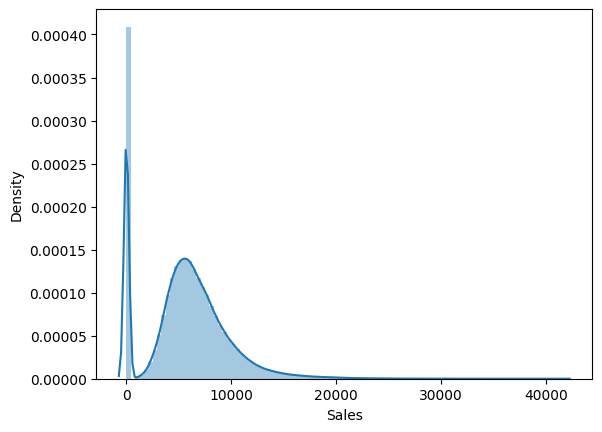

In [11]:
# visualize the distribution of sales
sns.distplot(train['Sales'],bins=100)
plt.show()

C:\Users\yumi4\AppData\Local\Temp\ipykernel_23112\159293706.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['Customers'],bins=100)


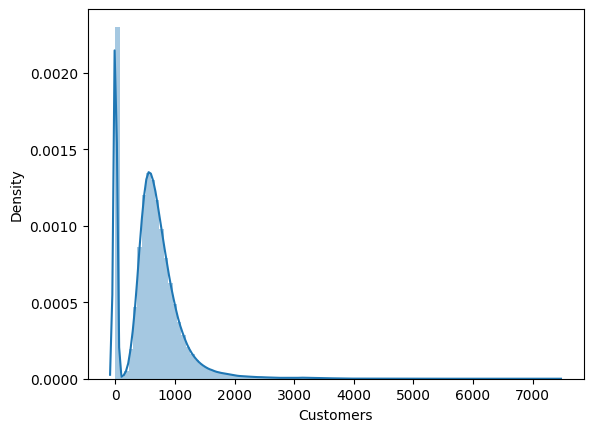

In [12]:
# visualize the distribution of customers
sns.distplot(train['Customers'],bins=100)
plt.show()

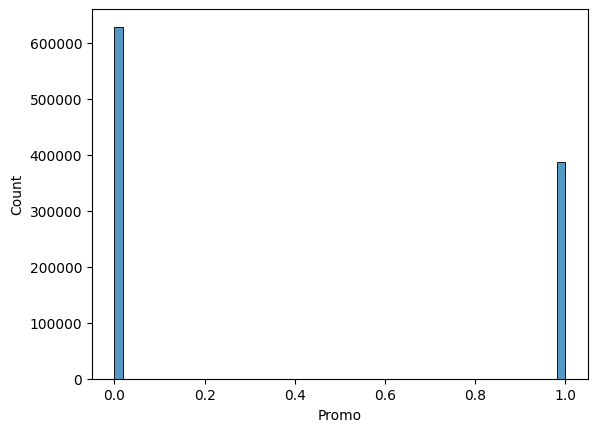

In [13]:
# visualize the distribution of promo
sns.histplot(train['Promo'])
plt.show()

We can see that promo is a binary variable.

#### Exploration of the relationships between variables

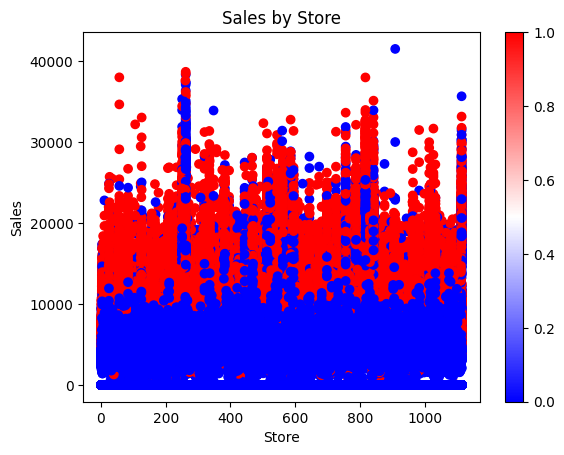

In [14]:
# explore relationships between promo and sales
# sns.scatterplot(x='Promo', y='Sales', data=train)
# plt.show()

plt.scatter(train['Store'], train['Sales'], c=train['Promo'], cmap='bwr')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.title('Sales by Store')
plt.colorbar()
plt.show()


We can see that it is more likley that there was no sales when there was no promo, but there are anomalies (i.e. more than 40000 sales with no promo).

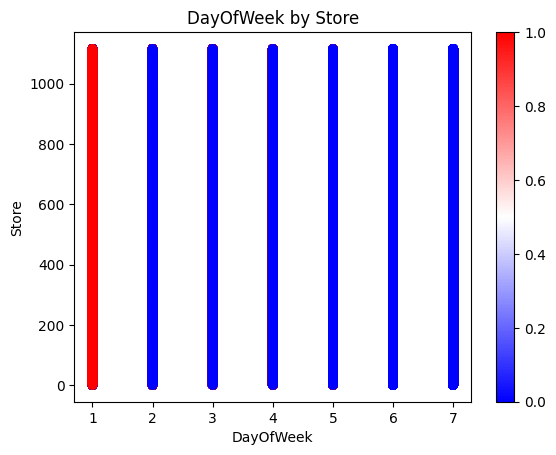

In [15]:
# explore relationships between promo and sales
# sns.scatterplot(x='Promo', y='DayOfWeek', data=train)
# plt.show()
plt.scatter(train['DayOfWeek'],train['Store'], c=train['Promo'], cmap='bwr')
plt.xlabel('DayOfWeek')
plt.ylabel('Store')
plt.title('DayOfWeek by Store')
plt.colorbar()
plt.show()

We can see that there are no promos on Sunday.

Check for missing values:

In [16]:
print(train.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


In [17]:
#print(test.isnull().sum())

In [18]:
print(store.isnull().sum())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [19]:
train['Date'] = pd.to_datetime(train['Date'])
train['Open'] = train['Open'].astype(bool)
train['Promo'] = train['Promo'].astype(bool)
train['SchoolHoliday'] = train['SchoolHoliday'].astype(bool)
print(train['StateHoliday'].unique())
train['StateHoliday'] = train['StateHoliday'].replace({0:'0'})
print(train['StateHoliday'].unique())
train.head()

['0' 'a' 'b' 'c' 0]
['0' 'a' 'b' 'c']


Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555  True   True            0   
1      2          5 2015-07-31   6064        625  True   True            0   
2      3          5 2015-07-31   8314        821  True   True            0   
3      4          5 2015-07-31  13995       1498  True   True            0   
4      5          5 2015-07-31   4822        559  True   True            0   

   SchoolHoliday  
0           True  
1           True  
2           True  
3           True  
4           True

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  bool          
 6   Promo          1017209 non-null  bool          
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  bool          
dtypes: bool(3), datetime64[ns](1), int64(4), object(1)
memory usage: 49.5+ MB


In [21]:
# test['Date'] = pd.to_datetime(test['Date'])
# test['Open'] = test['Open'].astype(bool)
# test['Promo'] = test['Promo'].astype(bool)
# test['SchoolHoliday'] = test['SchoolHoliday'].astype(bool)
# print(test['StateHoliday'].unique())
# test.head()

In [22]:
store['Promo2'] = store['Promo2'].astype(bool)
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   bool   
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: bool(1), float64(5), int64(1), object(3)
memory usage: 79.6+ KB


<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


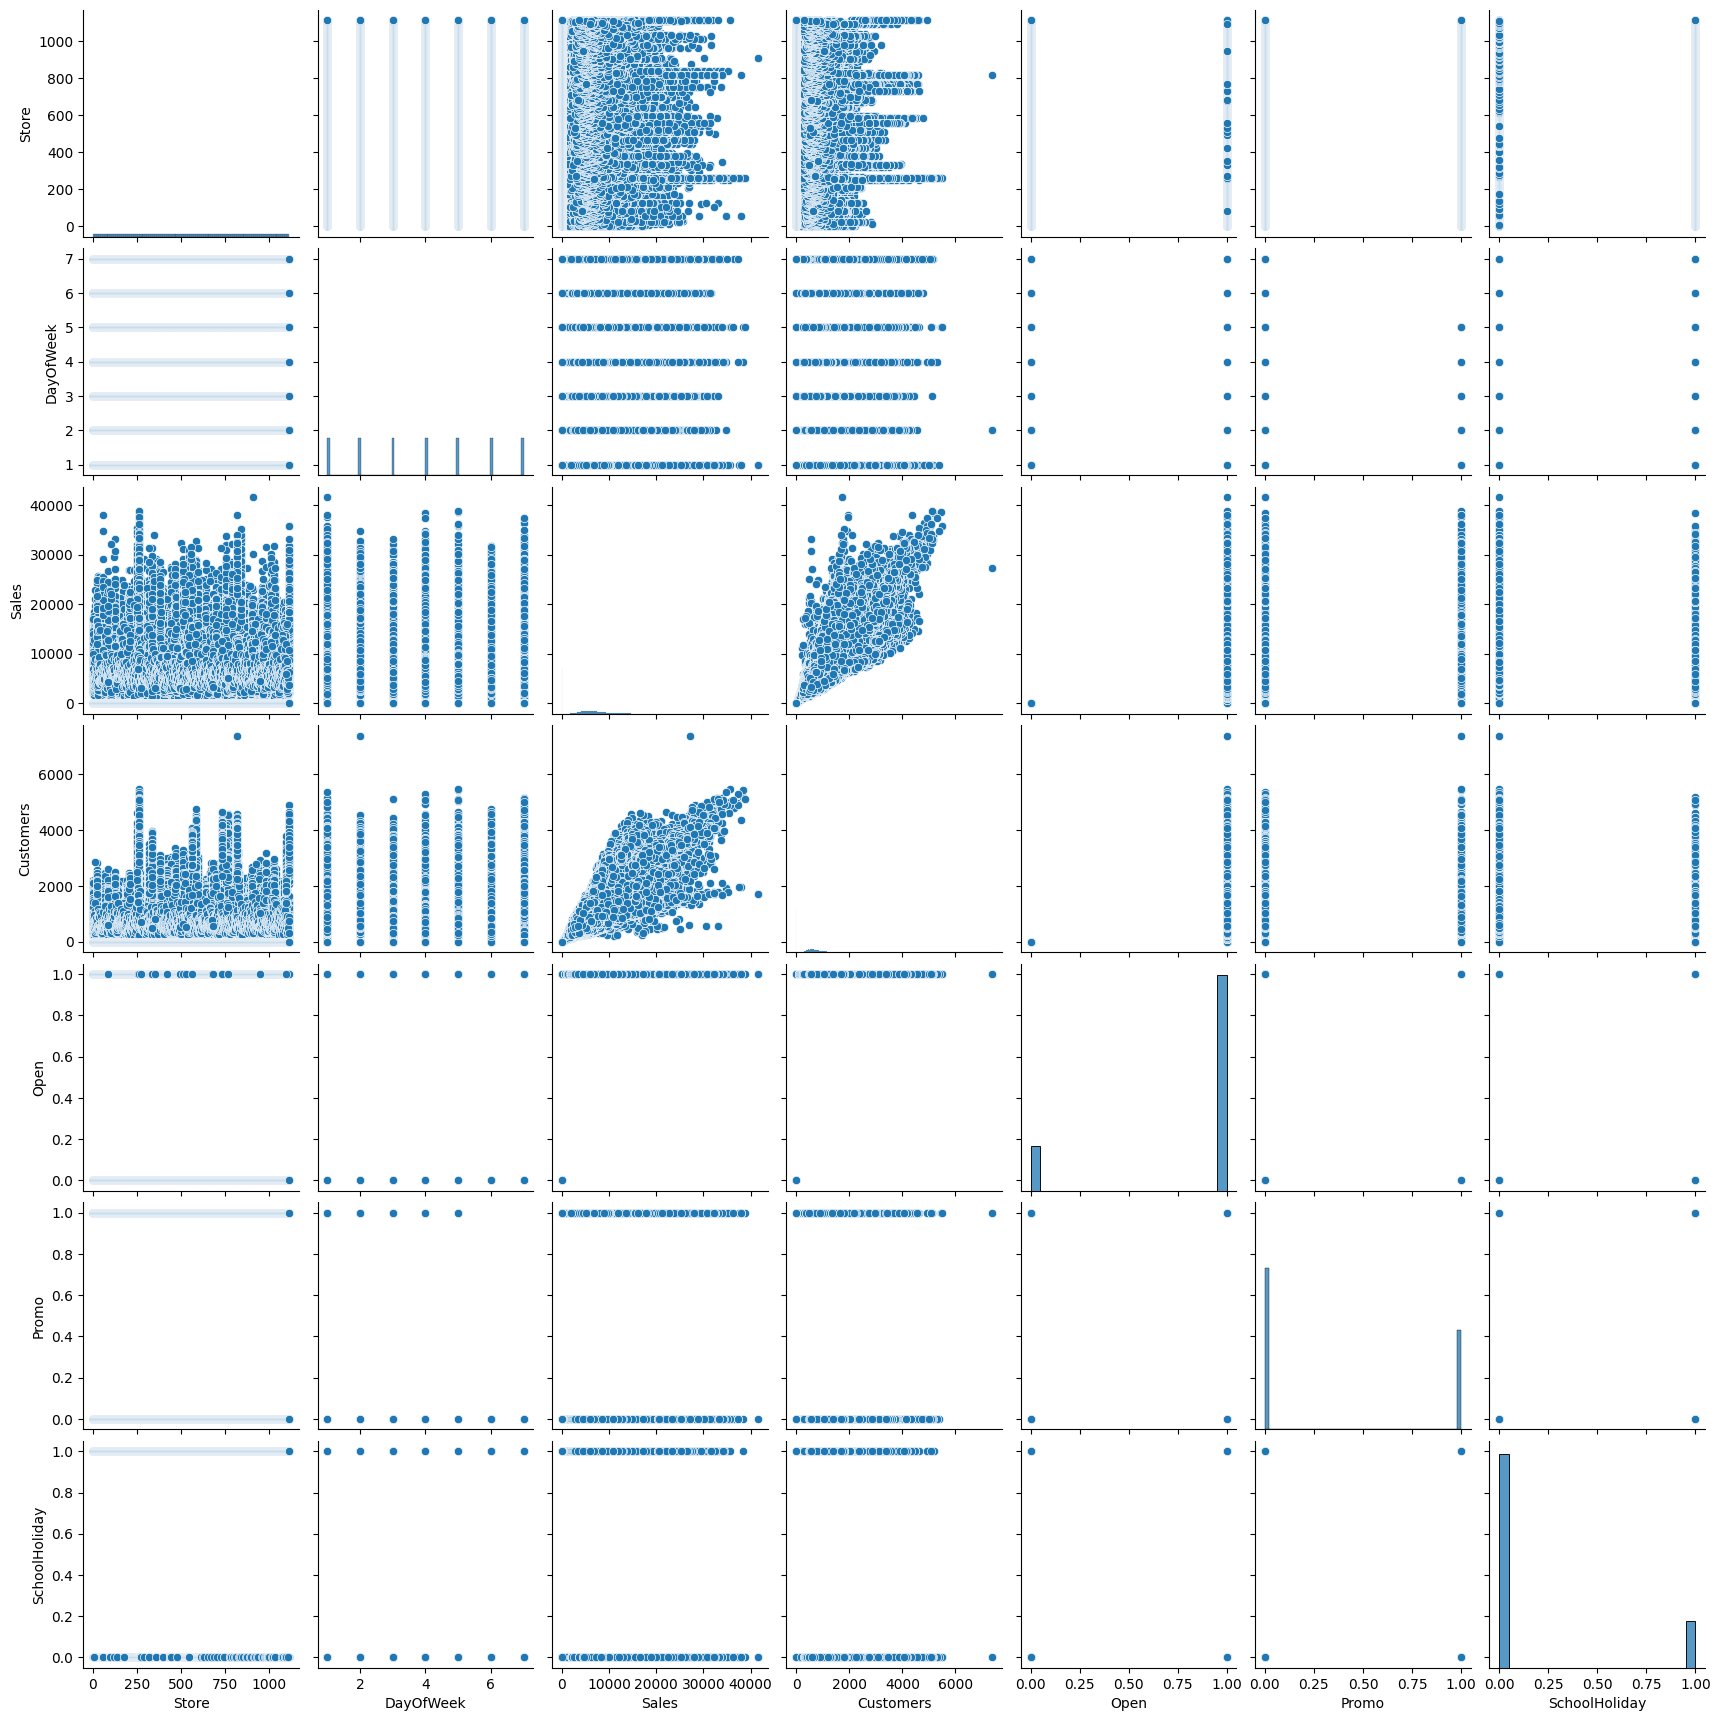

In [23]:
sns.pairplot(train)

In [25]:
train.corr().style.background_gradient(cmap="GnBu")

C:\Users\yumi4\AppData\Local\Temp\ipykernel_23112\2052744557.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr().style.background_gradient(cmap="GnBu")


We can see there is high correlation between customers and sales, which makes sense, so we will drop 'Customers' column.

In [26]:
train = train.drop(columns=['Customers'], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Open           1017209 non-null  bool          
 5   Promo          1017209 non-null  bool          
 6   StateHoliday   1017209 non-null  object        
 7   SchoolHoliday  1017209 non-null  bool          
dtypes: bool(3), datetime64[ns](1), int64(3), object(1)
memory usage: 41.7+ MB


<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


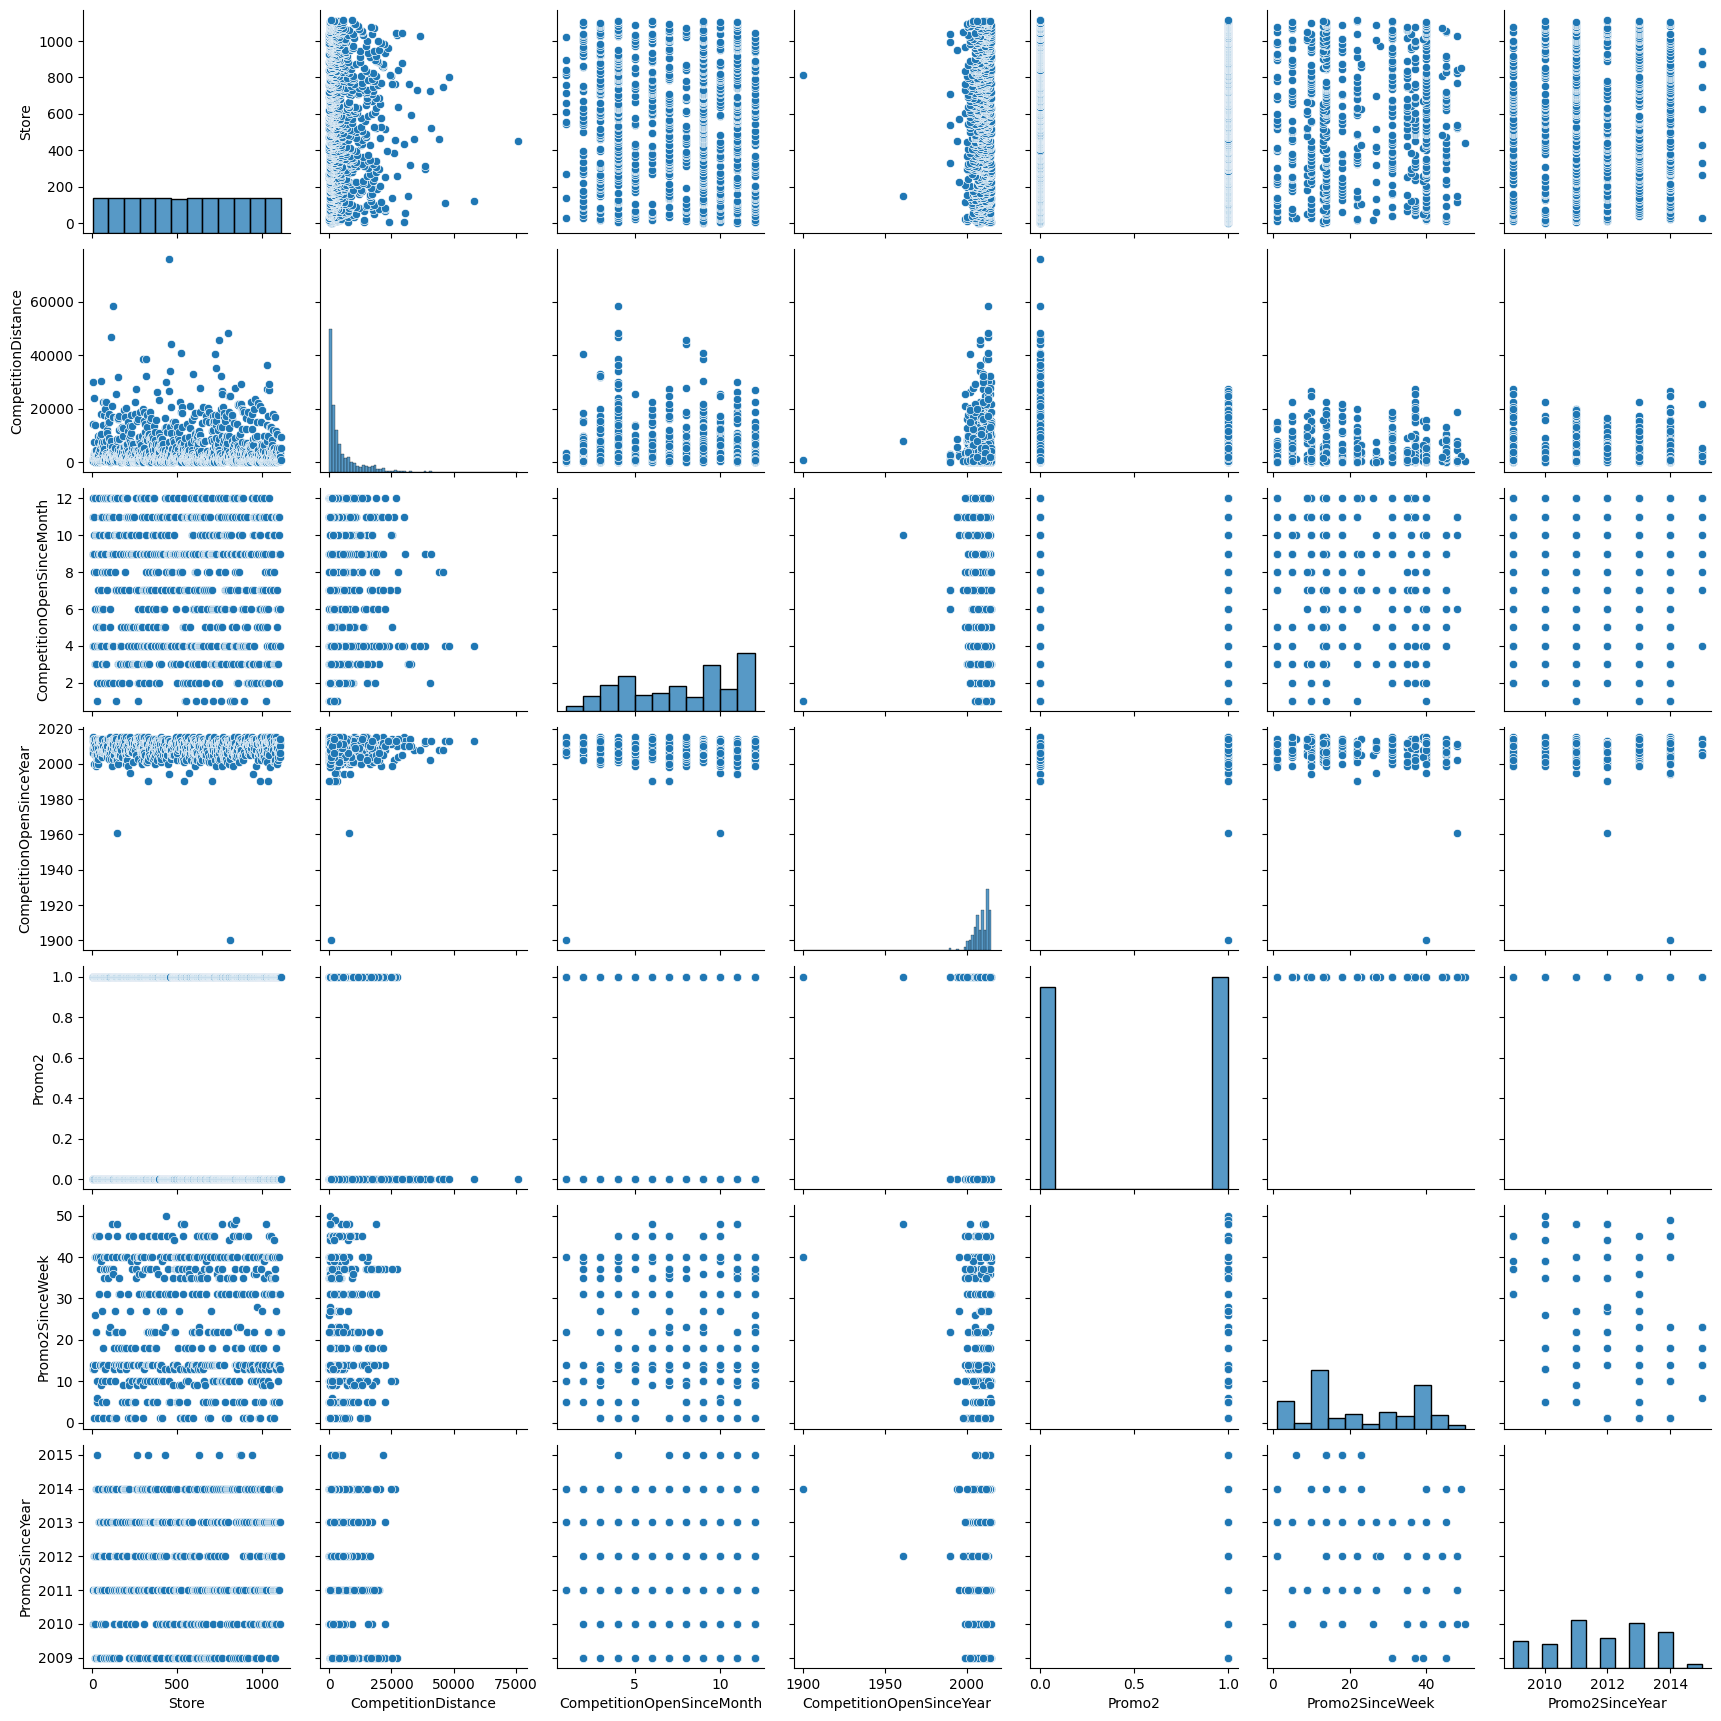

In [27]:
sns.pairplot(store)

In [28]:
train_copy = train.copy()
train_copy = train_copy[train_copy['Promo']==0]
train_copy['Promo'].unique()

array([False])

In [29]:
train_copy = train_copy[train_copy['SchoolHoliday']==0]
train_copy['SchoolHoliday'].unique()

array([False])

In [30]:
train_copy = train_copy[train_copy['StateHoliday']=='0']
train_copy['StateHoliday'].unique()

array(['0'], dtype=object)

In [31]:
train_copy = train_copy[train_copy['Open']==1]
train_copy['Open'].unique()

array([ True])

In [32]:
train_for_samples = train_copy[['Store','Date','Sales']]
train_for_samples

Store       Date  Sales
5659        85 2015-07-26  11421
5696       122 2015-07-26   5773
5783       209 2015-07-26   3742
5833       259 2015-07-26  15998
5836       262 2015-07-26  32547
...        ...        ...    ...
1014946   1082 2013-01-03   7303
1014954   1090 2013-01-03   4607
1014957   1093 2013-01-03   8371
1014962   1098 2013-01-03   4591
1014972   1108 2013-01-03   4779

[381559 rows x 3 columns]

For sampling by dates:

In [33]:
train_for_samples['Date'].max()

Timestamp('2015-07-26 00:00:00')

In [34]:
train_for_samples['Date'].min()

Timestamp('2013-01-03 00:00:00')

In [35]:
train_for_samples['Store'] = train_for_samples['Store'].astype(str)

C:\Users\yumi4\AppData\Local\Temp\ipykernel_23112\834338899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_for_samples['Store'] = train_for_samples['Store'].astype(str)


In [36]:
train_for_samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381559 entries, 5659 to 1014972
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Store   381559 non-null  object        
 1   Date    381559 non-null  datetime64[ns]
 2   Sales   381559 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 11.6+ MB


In [37]:
train_for_samples.describe()

Sales
count  381559.000000
mean     5874.868277
std      2584.161231
min         0.000000
25%      4210.000000
50%      5432.000000
75%      6962.000000
max     41551.000000

## SPC

First, we want to understand the sales distribution:

Fitting 4 distributions: 100%|██████████| 4/4 [00:24<00:00,  6.03s/it]


sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm     2.418298e-09  3240.136467 -1.247397e+07     inf      0.021869   
beta        5.084040e-09  3845.666591 -1.219045e+07     inf      0.038639   
norm        2.955336e-08  7238.333170 -1.151889e+07     inf      0.093239   
gamma       1.995326e-07  2399.715017 -1.079019e+07     inf      0.360869   

             ks_pvalue  
lognorm  5.878795e-159  
beta      0.000000e+00  
norm      0.000000e+00  
gamma     0.000000e+00

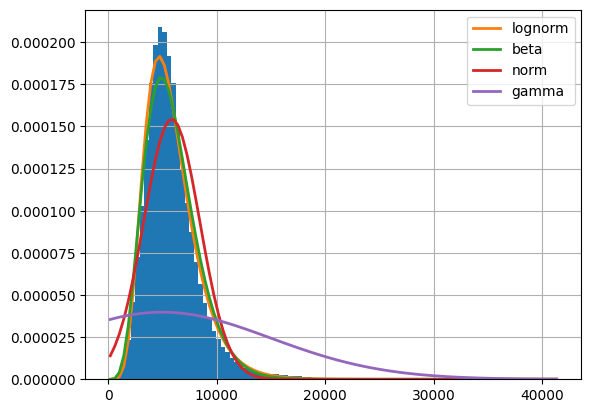

In [38]:
sales = train_for_samples['Sales'].values
f = Fitter(sales,
           distributions=['gamma',
                          "beta",
                          "lognorm",
                          "norm"])
f.fit()
f.summary()

In [39]:
f.get_best(method = 'sumsquare_error')

{'lognorm': {'s': 0.35966446318887624,
  'loc': -721.7920576849617,
  'scale': 6174.8026151649465}}

In [40]:
train_for_samples.sort_values(by='Date',ascending=False)

Store       Date  Sales
5659       85 2015-07-26  11421
6104      530 2015-07-26   6595
5696      122 2015-07-26   5773
6673     1099 2015-07-26   5683
6671     1097 2015-07-26  13307
...       ...        ...    ...
1014308   444 2013-01-03  11559
1014307   443 2013-01-03   4226
1014302   438 2013-01-03   2539
1014301   437 2013-01-03   5478
1014972  1108 2013-01-03   4779

[381559 rows x 3 columns]

In [41]:
store['Store'] = store['Store'].astype(str)

In [42]:
store[store['Store']=='85']

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
84    85         b          a               1870.0                       10.0   

    CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
84                    2011.0   False              NaN              NaN   

   PromoInterval  
84           NaN

In [43]:
train_for_samples = pd.merge(train_for_samples, store[['Store','Assortment']], left_on='Store', right_on='Store', how='left')
train_for_samples

Store       Date  Sales Assortment
0         85 2015-07-26  11421          a
1        122 2015-07-26   5773          c
2        209 2015-07-26   3742          c
3        259 2015-07-26  15998          b
4        262 2015-07-26  32547          a
...      ...        ...    ...        ...
381554  1082 2013-01-03   7303          a
381555  1090 2013-01-03   4607          a
381556  1093 2013-01-03   8371          c
381557  1098 2013-01-03   4591          a
381558  1108 2013-01-03   4779          a

[381559 rows x 4 columns]

In [44]:
a_for_samples = train_for_samples[train_for_samples['Assortment']=='a']
a_for_samples = a_for_samples.drop('Assortment',axis=1)
a_for_samples

Store       Date  Sales
0         85 2015-07-26  11421
4        262 2015-07-26  32547
8        335 2015-07-26   7988
10       423 2015-07-26  16014
13       494 2015-07-26   7804
...      ...        ...    ...
381552  1035 2013-01-03   5154
381554  1082 2013-01-03   7303
381555  1090 2013-01-03   4607
381557  1098 2013-01-03   4591
381558  1108 2013-01-03   4779

[200483 rows x 3 columns]

In [45]:
b_for_samples = train_for_samples[train_for_samples['Assortment']=='b']
b_for_samples = b_for_samples.drop('Assortment',axis=1)
b_for_samples

Store       Date  Sales
3        259 2015-07-26  15998
5        274 2015-07-26   7750
9        353 2015-07-26   9788
14       512 2015-07-26   7905
18       676 2015-07-26  13966
...      ...        ...    ...
380724   353 2013-01-05   2224
381060   733 2013-01-05  10674
381093   769 2013-01-05   6877
381254   948 2013-01-05   3220
381392  1097 2013-01-05   5460

[4151 rows x 3 columns]

In [46]:
c_for_samples = train_for_samples[train_for_samples['Assortment']=='c']
c_for_samples = c_for_samples.drop('Assortment',axis=1)
c_for_samples

Store       Date  Sales
1        122 2015-07-26   5773
2        209 2015-07-26   3742
6        299 2015-07-26   4865
7        310 2015-07-26   3159
11       433 2015-07-26   2143
...      ...        ...    ...
381542   978 2013-01-03   5879
381545   993 2013-01-03   7475
381548   999 2013-01-03   8475
381553  1074 2013-01-03   3613
381556  1093 2013-01-03   8371

[176925 rows x 3 columns]

We can see that sales are coming from normal distirbution. We will use this for buliding UCL and LCL.

In [47]:
def sample_sales(train_for_samples:pd.DataFrame()) -> pd.DataFrame():
    np.random.seed(42)
    samples = pd.DataFrame(columns=['date','sales','sample_group'])
    for i in range(10):
        # sample data for store sales
        sales_samples = train_for_samples.sample(n=100)
        # calculate the mean and standard deviation of the data
        mean = np.mean(sales_samples['Sales'])
        std_dev = np.std(sales_samples['Sales'])
        to_samples = {'date':sales_samples['Date'],'sales':sales_samples['Sales'],'sample_group':np.repeat(i,len(sales_samples))}
        to_samples = pd.DataFrame(to_samples)
        # print(to_samples.head())
        samples = pd.concat([samples,to_samples])
        # print(samples)
    # samples = samples.sort_values(by='date',ascending=False)
    return samples

In [48]:
a_samples = sample_sales(a_for_samples)
a_samples

date sales sample_group
379780 2013-01-12  6496            0
55613  2015-03-23  5435            0
110545 2014-10-27  7746            0
213762 2014-02-08  2258            0
69918  2015-02-24  4218            0
...           ...   ...          ...
179942 2014-04-08  4281            9
130372 2014-08-30  4082            9
241358 2013-11-30  2826            9
102750 2014-11-20  4043            9
96081  2014-12-10  3803            9

[1000 rows x 3 columns]

In [49]:
b_samples = sample_sales(b_for_samples)
b_samples

date  sales sample_group
133896 2014-08-17   7273            0
372623 2013-01-20   8229            0
267006 2013-10-06  16079            0
118795 2014-09-26   8790            0
61272  2015-03-11   7850            0
...           ...    ...          ...
368521 2013-01-30   3129            9
257983 2013-10-31   7317            9
106952 2014-11-09   6822            9
111683 2014-10-19  11755            9
170480 2014-05-12   7004            9

[1000 rows x 3 columns]

In [50]:
c_samples = sample_sales(c_for_samples)
c_samples

date  sales sample_group
55705  2015-03-23   6326            0
330894 2013-04-27   7171            0
313990 2013-06-12   7821            0
377053 2013-01-16   1734            0
355536 2013-02-26   6980            0
...           ...    ...          ...
40611  2015-04-24  10294            9
291904 2013-08-10   5363            9
52627  2015-03-26   5329            9
207030 2014-02-15  13028            9
362748 2013-02-12   6535            9

[1000 rows x 3 columns]

Make X_bar dataframe:

In [51]:
def set_x_bar_r(samples:pd.DataFrame())->pd.DataFrame():
    # Group masures by sample groups (x_bar)
    samples_grouped = samples[['sales','sample_group']].groupby('sample_group').mean()
    # Rename x-bar column
    samples_grouped.columns = ['x_bar']
    # Add R (range) column
    samples_max = samples[['sales','sample_group']].groupby('sample_group').max()
    samples_min = samples[['sales','sample_group']].groupby('sample_group').min()
    samples_grouped['R'] = samples_max['sales'] - samples_min['sales']
    # Get control limits
    samples_grouped['x_bar_bar'] = statistics.mean(samples_grouped['x_bar'])
    samples_grouped['UCL'] = statistics.mean(samples_grouped['x_bar'])+(0.577*statistics.mean(samples_grouped['R']))
    samples_grouped['+2s'] =(samples_grouped['UCL']-samples_grouped['x_bar_bar'])/3*2+samples_grouped['x_bar_bar']
    samples_grouped['+1s'] =(samples_grouped['UCL']-samples_grouped['x_bar_bar'])/3*1+samples_grouped['x_bar_bar']
    samples_grouped['-1s'] = samples_grouped['x_bar_bar']-(samples_grouped['UCL']-samples_grouped['x_bar_bar'])/3*1
    samples_grouped['-2s'] = samples_grouped['x_bar_bar']- (samples_grouped['UCL']-samples_grouped['x_bar_bar'])/3*2
    samples_grouped['LCL'] = statistics.mean(samples_grouped['x_bar'])-(0.577*statistics.mean(samples_grouped['R']))
    return samples_grouped

In [52]:
a_x = set_x_bar_r(a_samples)
a_x

x_bar      R  x_bar_bar        UCL           +2s          +1s  \
sample_group                                                                    
0             5656.41  15789    5302.69  12354.207  10003.701333  7653.195667   
1             5093.82  10197    5302.69  12354.207  10003.701333  7653.195667   
2             5134.84  14633    5302.69  12354.207  10003.701333  7653.195667   
3             5661.08  14655    5302.69  12354.207  10003.701333  7653.195667   
4             5117.29   9707    5302.69  12354.207  10003.701333  7653.195667   
5             4949.15   8832    5302.69  12354.207  10003.701333  7653.195667   
6             5588.17  11752    5302.69  12354.207  10003.701333  7653.195667   
7             5334.22  12787    5302.69  12354.207  10003.701333  7653.195667   
8             5248.01  11172    5302.69  12354.207  10003.701333  7653.195667   
9             5243.91  12686    5302.69  12354.207  10003.701333  7653.195667   

                      -1s         -2s       LCL  
sample_group                                     
0             2952.184333  601.678667 -1748.827  
1             2952.184333  601.678667 -1748.827  
2             2952.184333  601.678667 -1748.827  
3             2952.184333  601.678667 -1748.827  
4             2952.184333  601.678667 -1748.827  
5             2952.184333  601.678667 -1748.827  
6             2952.184333  601.678667 -1748.827  
7             2952.184333  601.678667 -1748.827  
8             2952.184333  601.678667 -1748.827  
9             2952.184333  601.678667 -1748.827

In [53]:
b_x = set_x_bar_r(b_samples)
b_x

x_bar      R  x_bar_bar         UCL         +2s         +1s  \
sample_group                                                                  
0             8905.82  15343   8528.151  17363.3481  14418.2824  11473.2167   
1             8194.57  16277   8528.151  17363.3481  14418.2824  11473.2167   
2             8092.25  16467   8528.151  17363.3481  14418.2824  11473.2167   
3             8969.23  16557   8528.151  17363.3481  14418.2824  11473.2167   
4             8073.62  15725   8528.151  17363.3481  14418.2824  11473.2167   
5             8658.57  15416   8528.151  17363.3481  14418.2824  11473.2167   
6             8804.56  14323   8528.151  17363.3481  14418.2824  11473.2167   
7             8395.91  14503   8528.151  17363.3481  14418.2824  11473.2167   
8             8395.43  14575   8528.151  17363.3481  14418.2824  11473.2167   
9             8791.55  13937   8528.151  17363.3481  14418.2824  11473.2167   

                    -1s        -2s       LCL  
sample_group                                  
0             5583.0853  2638.0196 -307.0461  
1             5583.0853  2638.0196 -307.0461  
2             5583.0853  2638.0196 -307.0461  
3             5583.0853  2638.0196 -307.0461  
4             5583.0853  2638.0196 -307.0461  
5             5583.0853  2638.0196 -307.0461  
6             5583.0853  2638.0196 -307.0461  
7             5583.0853  2638.0196 -307.0461  
8             5583.0853  2638.0196 -307.0461  
9             5583.0853  2638.0196 -307.0461

In [54]:
c_x = set_x_bar_r(c_samples)
c_x

x_bar      R  x_bar_bar         UCL         +2s        +1s  \
sample_group                                                                 
0             6305.35  16737   6162.909  14389.3134  11647.1786  8905.0438   
1             6328.39  10094   6162.909  14389.3134  11647.1786  8905.0438   
2             6035.95  13661   6162.909  14389.3134  11647.1786  8905.0438   
3             6070.92  16918   6162.909  14389.3134  11647.1786  8905.0438   
4             6641.78  13772   6162.909  14389.3134  11647.1786  8905.0438   
5             5943.73  17781   6162.909  14389.3134  11647.1786  8905.0438   
6             5994.78  11250   6162.909  14389.3134  11647.1786  8905.0438   
7             6331.62  18989   6162.909  14389.3134  11647.1786  8905.0438   
8             5852.96   9651   6162.909  14389.3134  11647.1786  8905.0438   
9             6123.61  13719   6162.909  14389.3134  11647.1786  8905.0438   

                    -1s       -2s        LCL  
sample_group                                  
0             3420.7742  678.6394 -2063.4954  
1             3420.7742  678.6394 -2063.4954  
2             3420.7742  678.6394 -2063.4954  
3             3420.7742  678.6394 -2063.4954  
4             3420.7742  678.6394 -2063.4954  
5             3420.7742  678.6394 -2063.4954  
6             3420.7742  678.6394 -2063.4954  
7             3420.7742  678.6394 -2063.4954  
8             3420.7742  678.6394 -2063.4954  
9             3420.7742  678.6394 -2063.4954

Plot x-bar control chart:

In [55]:
def plot_x_bar(samples_grouped):
# Line chart
    line_plot = samples_grouped.hvplot.line(
                                x='sample_group',
                                y=['x_bar','UCL','+2s','+1s','x_bar_bar','-1s','-2s','LCL'],
                                xlabel="Sample Group",
                                title="x-bar chart",
                                height=500,
                                width=1000)

    # Scatter plot
    scatter_plot = samples_grouped.hvplot.scatter(
                                x='sample_group',
                                y=['x_bar','UCL','+2s','+1s','x_bar_bar','-1s','-2s','LCL'],
                                xlabel="Sample Group",
                                title="x-bar chart",
                                height=500,
                                width=1000)

    # Merge line chart and scatter plot into a single plot
    x_bar_chart = line_plot*scatter_plot
    return x_bar_chart

In [56]:
plot_x_bar(a_x)

:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [sample_group]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Scatter   [sample_group]   (value)

In [57]:
plot_x_bar(b_x)

:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [sample_group]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Scatter   [sample_group]   (value)

In [58]:
plot_x_bar(c_x)

:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [sample_group]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Scatter   [sample_group]   (value)

In [59]:
# TODO: Calculate power (1-beta) of this control charts

## K Means Clustering

In [60]:
# def standartize(train_for_samples:pd.DataFrame()) -> pd.DataFrame():
#     ss = StandardScaler()
#     sales_clustering = pd.DataFrame(ss.fit_transform(train_for_samples), columns=['Sales'])
#     return sales_clustering

In [61]:
# a_clustering = standartize(a_for_samples)
# a_clustering

Visualization:

In [62]:
def plot_sales_vs_date (train_for_samples:pd.DataFrame()):
    plt.figure(figsize=(12,6))
    train_for_samples['Store']=train_for_samples['Store'].astype(int)
    plt.scatter(x=train_for_samples.Date, y=train_for_samples.Sales,c=train_for_samples.Store,cmap='bwr')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Scatter plot of Sales vs. Date')
    plt.colorbar()
    plt.show()

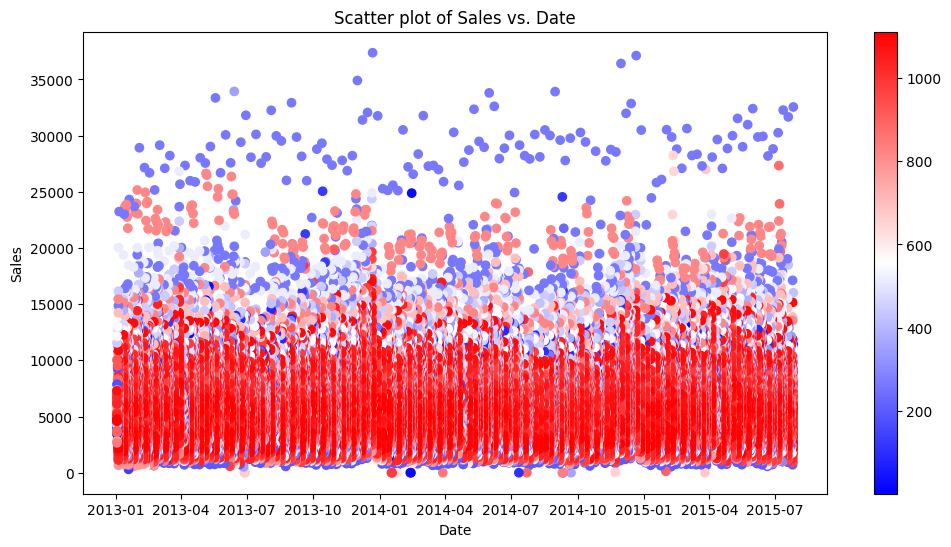

In [63]:
plot_sales_vs_date(a_for_samples)

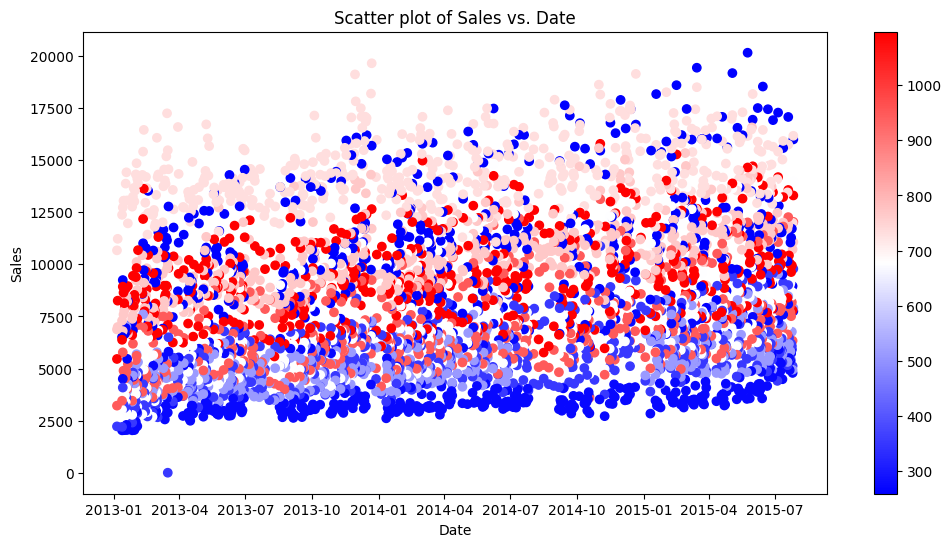

In [64]:
plot_sales_vs_date(b_for_samples)

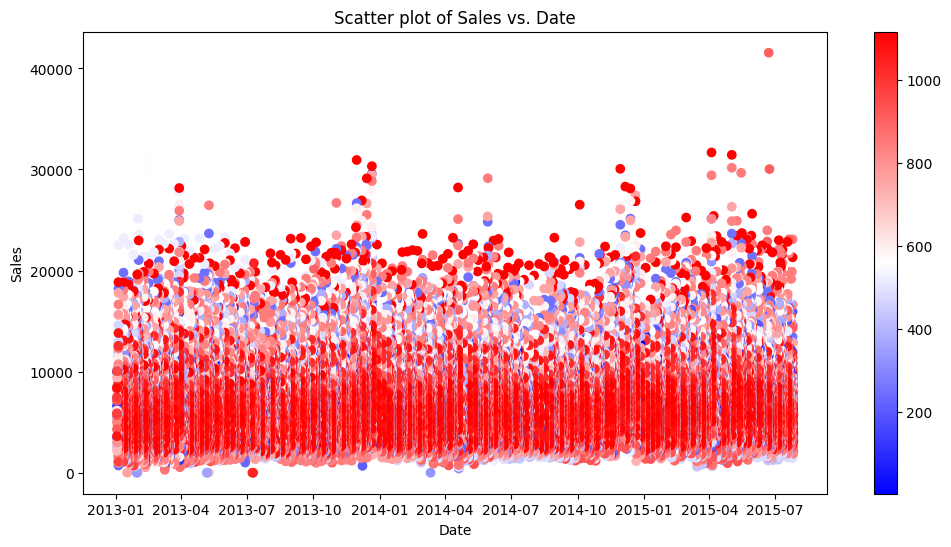

In [65]:
plot_sales_vs_date(c_for_samples)

Creating K-Means Clustering:

In [66]:
a_km = KMeans(n_clusters=3)
a_for_samples['Date'] = a_for_samples['Date'].astype(str)
model = a_km.fit(a_for_samples[['Date','Sales']])

ValueError: could not convert string to float: '2015-07-26'

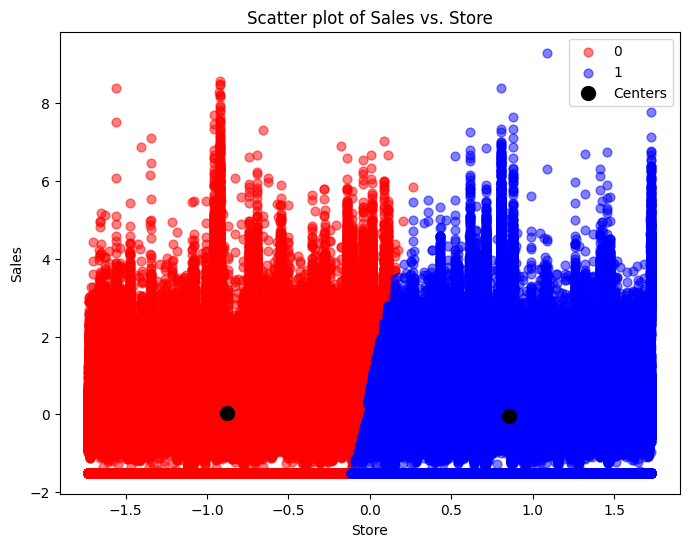

In [ ]:
colors=["red","blue","green","orange"]
# figure setting
plt.figure(figsize=(8,6))
for i in range(np.max(model.labels_)+1):
    plt.scatter(sales_clustering[model.labels_==i].Store, sales_clustering[model.labels_==i].Sales, label=i, c=colors[i], alpha=0.5, s=40)
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], label='Centers', c="black", s=100)
plt.title("K-Means Clustering of Sales Data",size=20)
plt.xlabel("Store")
plt.ylabel("Sales")
plt.title('Scatter plot of Sales vs. Store')
plt.legend()
plt.show()

In [ ]:
def distance_from_center(store, sales, label):
    '''
    Calculate the Euclidean distance between a data point and the center of its cluster.
:param float income: the standardized income of the data point 
    :param float age: the standardized age of the data point 
    :param int label: the label of the cluster
    :rtype: float
    :return: The resulting Euclidean distance  
    '''
    center_store =  model.cluster_centers_[label,0]
    center_sales =  model.cluster_centers_[label,1]
    distance = np.sqrt((store - center_store) ** 2 + (sales - center_sales) ** 2)
    return np.round(distance, 3)
sales_clustering['label'] = model.labels_
sales_clustering['distance'] = distance_from_center(sales_clustering.Store, sales_clustering.Sales, sales_clustering.label)

In [ ]:
outliers_idx = list(sales_clustering.sort_values('distance', ascending=False).head(10).index)
outliers = sales_clustering[sales_clustering.index.isin(outliers_idx)]
print(outliers)

           Store     Sales  label  distance
44393   1.089037  9.292957      1     9.338
87231  -0.920851  8.465928      0     8.422
101726 -0.920851  8.496318      0     8.453
132946 -0.920851  8.558137      0     8.515
245945 -0.920851  8.142545      0     8.099
424086 -1.557678  8.380212      0     8.364
444361 -0.920851  8.215533      0     8.172
620531 -0.920851  8.208520      0     8.165
627220 -0.923957  8.278651      0     8.235
627776  0.803242  8.377095      1     8.420


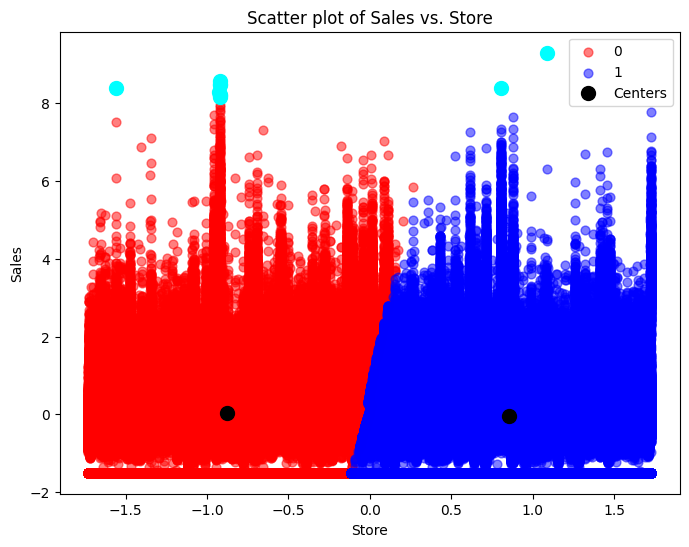

In [ ]:
# figure setting
plt.figure(figsize=(8,6))
for i in range(np.max(model.labels_)+1):
    plt.scatter(sales_clustering[model.labels_==i].Store, sales_clustering[model.labels_==i].Sales, label=i, c=colors[i], alpha=0.5, s=40)
plt.scatter(outliers.Store, outliers.Sales, c='aqua', s=100)
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], label='Centers', c="black", s=100)
plt.title("K-Means Clustering of Sales Data",size=20)
plt.xlabel("Store")
plt.ylabel("Sales")
plt.title('Scatter plot of Sales vs. Store')
plt.legend()
plt.show()